# Monet Style Generator GAN

**This notebook is to satisfy a weekly homework in Deep Neural Networks Class at the University of Colorado, Boulder. The notebook must score under 1000 for credit in this week's class.

In this exciting research endeavor, we embark on the intersection of art and technology, leveraging the power of generative adversarial networks (GANs) to replicate the distinctive style of the renowned artist Claude Monet. The challenge at hand involves the creation of a GAN composed of a generator model and a discriminator model, with the former tasked to generate images in the distinct style of Monet. The intricate dance between these two neural networks involves the generator attempting to deceive the discriminator, while the discriminator strives to accurately differentiate between real and generated images. The objective is to produce a substantial quantity of Monet-style images, ranging from 7,000 to 10,000, demonstrating the potential of data science in mimicking the artistic finesse traditionally associated with human creativity. Throughout this notebook, we will delve into the intricacies of GAN architecture, explore the nuances of Monet's style, and meticulously guide the reader through the steps of training a GAN to create visually compelling artworks that pay homage to the timeless elegance of Claude Monet.

This notebook uses the dataset available here: https://www.kaggle.com/competitions/gan-getting-started/data
* Data should consist of training images (Monets) and testing images (photos)
* There are roughly 300 training images, and 7000-10000 photos
* Images are shape (256,256,3) and have a RGB color channel configuration

This notebook will be scored as part of Kaggle Competition here:
https://www.kaggle.com/competitions/gan-getting-started/leaderboard

Work to do: 
1.	EDA – Exploratory Data Analysis
2.	Build Redundant Network Portions (Upsample and Downsample)
3.	Build Generator and Discriminator
4.	Build GAN 
5.	Train Model
6.	Inspect Results
7.	Make Photos for Submission
8.	Zip Paintings and Submit for Scoring  

# TLDR Scoring Results:

In [1]:
import pandas as pd
res = pd.DataFrame({'Reduction':['Auto','Auto','Auto','Auto','None'],
                    'Initializers StDev':[0.05,0.05,0.05,0.02,0.02],
                   'Epochs':[50,100,150,100,100],
                   'Score':[152.96,150.30,150.27,148.09,54.84]})
res

,Reduction,Initializers StDev,Epochs,Score
0,Auto,0.05,50,152.96
1,Auto,0.05,100,150.30
2,Auto,0.05,150,150.27
3,Auto,0.02,100,148.09
4,None,0.02,100,54.84


# Exploratory Data Analysis
The EDA for this task is pretty simple. Make sure we have enough images, and that they are indeed Monet and Photographic samples.

In [2]:
# # import the libraries
import tensorflow as tf
import keras
from tensorflow.keras import layers as L
print("TF Version:", tf.__version__ ,  "(Built on 2.13)")
AUTOTUNE = tf.data.AUTOTUNE

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import os, shutil
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



# # light up the gpu/tpus
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu_master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy= tf.distribute.TPUStrategy(tpu)
except:
    tpu_strategy = tf.distribute.get_strategy()
print("Replicas:", tpu_strategy.num_replicas_in_sync)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF Version: 2.13.0 (Built on 2.13)
Replicas: 1


In [3]:
# import the tfrecs
MONETS = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTOS = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
print(f"TFRecords:\nMonets: {len(MONETS)}, Photos: {len(PHOTOS)}")

# inspect the photos
print(f"\n\nPhotos:\n Number of Monet: {len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg'))} Number of Photos:{len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg'))}")

TFRecords:
Monets: 5, Photos: 20


Photos:
 Number of Monet: 300 Number of Photos:7038


We are half way through EDA. We know that the curator of this dataset has loaded all the photos into the TFRecords for us, that there are roughly 300 Monets, and >7000 photos to work with. Since >7000 photos satisfies the grading criteria, we move forward to seeing the images.

To see some images we'll need a few helper functions to decipher the tfrecs and images. While we are here, we will go ahead and normalize the photos between -1 and 1 for the models' use later. This step must be undone for viewing, and you'll see that in the matplotlib.pyplot calls below.

In [4]:
#set some variables

IMG_SIZE = 256
IMG_CHANNELS = 3

#build the helper functions to decode images, and tfrecs
def decode_image(image):
    image = tf.image.decode_image(image, channels = 3)
    image = tf.cast(image,tf.float32)
    # Normalize -1 to 1
    image = (image / 127.5) - 1
    
#     # Normalize 0 to 1
#     image = image/255

    return image

def read_tfrecord(rec):
    record_format = {
        "image_name" : tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    rec = tf.io.parse_single_example(rec, record_format)
    image = decode_image(rec['image'])
    return image

# build the datasets function
def build_dataset(files):
    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return ds

#build the datasets
monetds = build_dataset(MONETS).batch(1)
photods = build_dataset(PHOTOS).batch(1)



Monet:


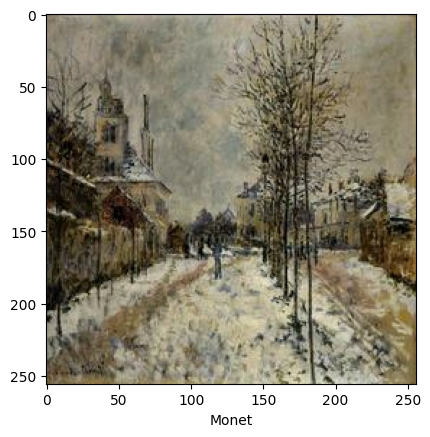



Photo:


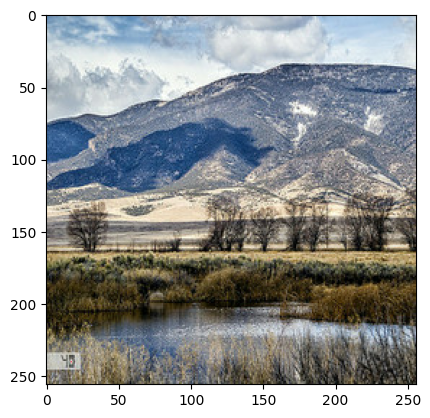

In [5]:
#test them
print('Monet:')
seemonet = next(iter(monetds)) 
plt.imshow(seemonet[0] * .5 + .5)
plt.xlabel("Monet")
plt.show()

print('\n\nPhoto:')
seephoto = next(iter(photods))
plt.imshow(seephoto[0] * .5 + .5)
plt.show()

Great, those look like nice photos.

Let's see if both have consistent usage of RGB channels. (AKA the histograms should look similar across each of the channels, showing the shading across the color spectrum. We expect the that the Monets will look different from the Photos.)

Monet Histogram


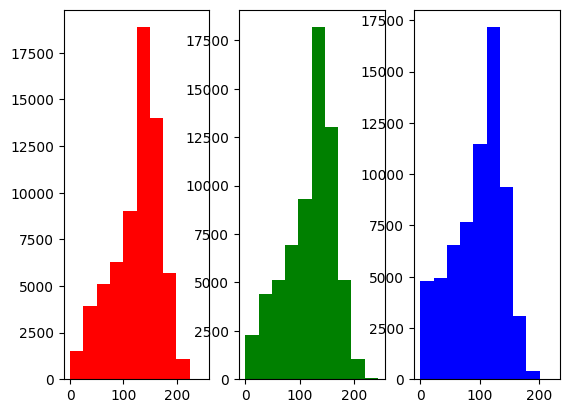

Photo Histogram:


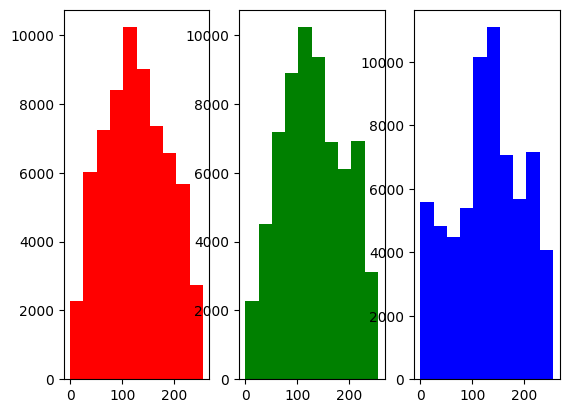

In [6]:
mon= seemonet.numpy().reshape(256,256,3)
mon = ((mon + 1) * 127.5).astype(np.uint8)

print("Monet Histogram")
fig,ax = plt.subplots(1,3)
ax[0].hist(mon[:,:,0].reshape(-1),color='r')
ax[1].hist(mon[:,:,1].reshape(-1),color='g')
ax[2].hist(mon[:,:,2].reshape(-1),color='b')
plt.show()


print("Photo Histogram:")
pho= seephoto.numpy().reshape(256,256,3)
pho = ((pho + 1) * 127.5).astype(np.uint8)
fig, ax = plt.subplots(1,3)
ax[0].hist(pho[:,:,0].reshape(-1),color='r')
ax[1].hist(pho[:,:,1].reshape(-1),color='g')
ax[2].hist(pho[:,:,2].reshape(-1),color='b')
plt.show()


Great. We have images of Monets and Photos. We have enough to complete the notebook and satisfy the 7000-10000 requirement. We can see that the RGB channels look similar in both photos and histograms. Let's move forward to modeling them.

# Build Redundant Parts of Networks

There are several layers of this GAN that will be repeated. We should build those in a way that can be reused. This will not only reduce complexity in later steps, it will allow us to focus on the details in later steps. We will build two functions, upsample and downsample. Upsample will increase the size of the signal. Downsample will decrease the size of the signal. Each will add layers to our generator and discriminator.

In [7]:
#build the inner workings of the generator and discriminator

def downsample(filters,size, applynorm=True):
    result = keras.Sequential([
        L.Conv2D(filters, size, strides = 2, padding = 'same',
                kernel_initializer = tf.random_normal_initializer(0,.02),
                use_bias = False)        
    ])
    if applynorm == True:
        result.add(tf.keras.layers.GroupNormalization(
                gamma_initializer = keras.initializers.RandomNormal(0,.02)))
    result.add(L.LeakyReLU())
    return result


def upsample(filters,size, applydropout=False):
    result = keras.Sequential([
        L.Conv2DTranspose(filters, size, strides=2,padding='same',
                         kernel_initializer = tf.random_normal_initializer(0,.02),
                         use_bias=False),
        L.GroupNormalization(gamma_initializer = keras.initializers.RandomNormal(0,.02))
    ])
    if applydropout:
        result.add(L.Dropout(.5))
    result.add(L.ReLU())
    return result

# Build Generator and Discriminator

The Generator must take a bit of noise and generate an image (hopefully a Monet styled painting). The Discriminator is required to determine if the result of the generator is indeed a Monet. Each of these is a Convolutional Neural Network. We will add a skip function to back propogate the weights during training.

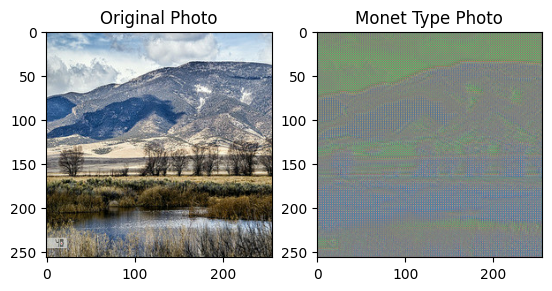

In [8]:
# define the generator and discriminator
def Generator():
    inputs = L.Input(shape=[IMG_SIZE,IMG_SIZE,IMG_CHANNELS])
    
    down_steps = [
        downsample(64, 4, applynorm=False), # (128, 128, 64)
        downsample(128, 4), # (64, 64, 128)
        downsample(256, 4), # (32, 32, 256)
        downsample(512, 4), # (16, 16, 512)
        downsample(512, 4), # (8, 8, 512)
        downsample(512, 4), # (4, 4, 512)
        downsample(512, 4), # (2, 2, 512)
        downsample(512, 4), # (1, 1, 512)
    ]

    up_steps = [
        upsample(512, 4, applydropout=True), # (2, 2, 1024)
        upsample(512, 4, applydropout=True), # (4, 4, 1024)
        upsample(512, 4, applydropout=True), # (8, 8, 1024)
        upsample(512, 4), # (16, 16, 1024)
        upsample(256, 4), # (32, 32, 512)
        upsample(128, 4), # (64, 64, 256)
        upsample(64, 4), # (128, 128, 128)
    ]
    
    last = L.Conv2DTranspose(IMG_CHANNELS, 4, strides=2, padding='same',
                                kernel_initializer = tf.random_normal_initializer(0,.2),
                                activation = 'tanh') 
                                #use tanh because we normalized -1 to 1
                                #if normalized 0 to 1, use sigmoid
    
    o = inputs
    steps = []
    for s in down_steps:
        o = s(o)
        steps.append(o)
    steps = reversed(steps[:-1])
    for u, step in zip(up_steps,steps):
        o = u(o)
        o = L.Concatenate()([o,step])
    o = last(o)
    return keras.Model(inputs = inputs, outputs = o)

def Discriminator():
    inputs = L.Input(shape=[IMG_SIZE,IMG_SIZE,IMG_CHANNELS])
    down1 = downsample(64, 4, False)(inputs) # (128, 128, 64)
    down2 = downsample(128, 4)(down1) # (64, 64, 128)
    down3 = downsample(256, 4)(down2) # (32, 32, 256)
    zero_pad1 = L.ZeroPadding2D()(down3) # (34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                         kernel_initializer=tf.random_normal_initializer(0., 0.02),
                         use_bias=False)(zero_pad1) # (31, 31, 512)
    norm1 = L.GroupNormalization(
        gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(conv)
    leaky_relu = L.LeakyReLU()(norm1)
    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (33, 33, 512)
    last = L.Conv2D(1, 4, strides=1,
                         kernel_initializer=tf.random_normal_initializer(0., 0.02))(zero_pad2) # (30, 30, 1)
    return tf.keras.Model(inputs=inputs, outputs=last)

# build them in scope
with tpu_strategy.scope():
    monet_generator = Generator() # transforms photos to Monet Type paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# test one (Pre Training - we expect terrible results)
testphoto = next(iter(photods))
testmonet = monet_generator(testphoto)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(testphoto[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet Type Photo")
plt.imshow(testmonet[0] * 0.5 + 0.5)
plt.show()

Great. We have a functional generator (although it remains untrained) and a discriminator ready to go. Now we need to build a GAN that is capable of training them.

# Build Cycle GAN

Special thank you to Amy Jang and her excellent tutorial here: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Although the tutorial is 3 years old, and needs several Tensorflow syntax improvements, the basic functionality is solid. 

In [9]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator,
            monet_discriminator, photo_discriminator, lambda_cycle=12):
        
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, 
                m_disc_optimizer, p_disc_optimizer, gen_loss_fn, 
                disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        real_monet = tf.reshape(real_monet, (1,IMG_SIZE,IMG_SIZE,IMG_CHANNELS))
        real_photo = tf.reshape(real_photo, (1,IMG_SIZE,IMG_SIZE,IMG_CHANNELS))
#         print("Real Monet Shape:", real_monet.shape)
#         print("Real Photo Shape:", real_photo.shape)
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
    
# nod to Amy Jang, and her excellent tutorial here: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Next, we need to define our loss functions, optimizers, and compile everything in the GPU/TPU strategy scope. Once we get past the errors, we will zip the datasets, and begin training.

In [19]:
with tpu_strategy.scope():
    #defined functions
    def disc_loss(real, generated):
        real_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction =  tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
        generated_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * .5
 
    def gen_loss(generated):
        return keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated) 
 
    def cycle_loss(real_image,cycled_image,LAMBDA):
        lossrel = tf.math.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * lossrel
    
    def ident_loss(real_image, same_image, LAMBDA):
        lossrel = tf.math.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * lossrel * .5

    # # defined optimizers (use all the same)
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(15e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(15e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(15e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(15e-4, beta_1=0.5)
    
#     monet_generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 12e-4, momentum = 0.005)
#     photo_generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 12e-4, momentum = 0.005)
#     monet_discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 12e-4, momentum = 0.005)
#     photo_discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 12e-4, momentum = 0.005)
    
    # define the model and build it up
    cgan = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cgan.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = gen_loss,
        disc_loss_fn = disc_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = ident_loss
    )

In [20]:
# no errors? Cool, zip the datasets, test em
finalds = tf.data.Dataset.zip(monetds,photods)
batchtest = (next(iter(finalds)))
batchtest[0].shape , batchtest[1].shape

(TensorShape([1, 256, 256, 3]), TensorShape([1, 256, 256, 3]))

# Train the Model
With all the legwork done above, we have a very simple set of code to define the epochs and train the model. We make sure to save the generator model for later use.

In [ ]:
#  and fit to the data.
cgan.fit(finalds, epochs=150)

# and save the model if training completes
monet_generator.save('/kaggle/working/monet_generator.keras')

Epoch 1/150


2024-01-26 23:24:29.188854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_10/dropout_2/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     73/Unknown - 66s 231ms/step - monet_gen_loss: 5.3798 - photo_gen_loss: 5.4847 - monet_disc_loss: 0.6717 - photo_disc_loss: 0.6581

# Inspect the Monets

Before we move on to the 7000+ images, we will inspect the images the model is generating. We take some photos from the photo dataset, apply the monet_generator, and inspect the outputs next to the originals.

In [ ]:
# Inspection time
fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(12,16))
fig.subplots_adjust(hspace=0.5)
h = 0
w = 0
for i , img in enumerate(photods.take(14)):
    pred = monet_generator(img,training=False)[0].numpy()
    pred = tf.cast((pred * 127.5 + 127.5),tf.dtypes.uint16)
    img = tf.cast((img[0] * 127.5 + 127.5),tf.dtypes.uint16)
    ax[h,w].imshow(img)
    ax[h,w].title.set_text("Input") 
    ax[h,w+1].imshow(pred)
    ax[h,w+1].title.set_text("Monet?")
    if w == 2:
        w = 0
        h +=1
    else:
        w+=2 
plt.show()

# Create 7000+ Monets
The inspection shows that we are indeed altering the images. Let's make the images for the competition, zip them up, and get a score.

In [ ]:
#they look good enough to get a score, make a folder, make images, zip'em
!mkdir ../tmp
clicker = 0
for img in photods:
    pred = monet_generator(img,training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5) 
    pred = tf.cast(pred, tf.int16) 
    Image.fromarray(pred.numpy(),mode='RGB').save("../tmp/"+str(clicker)+'.jpg')
    clicker +=1

shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/tmp')

# Conclusion
Making a GAN is a more difficult process than just building a generator, a discriminator, and linking them up. I found the nuances in Tensorflow releases took a considerable part of the time I spent on this weeks' assignment. In the future I would like to understand how to grid search the outputs against the scoring metric. In particular, defining the optimal number of epochs without a simple trial and error process seems valuable to me. I also would want to try several optimizers to see if they improve the output, reduce the training time, and enhance the process.

This was a good homework though. I enhanced my knowledge of loss functions, learned to use tfrecs, delved deeper into the different tensorflow versions,  and am getting better at troubleshooting models' syntax. 